# Analysing power density spectra of the dendtic signals
* only movement based at this point bc no EEG data analyzed yet
* 1/27/24 setup

In [22]:
import sys
import json
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import scipy.signal as signal
import numpy as np
import scipy.stats as stats

sys.path.append("/home/gergely/code/sleep/src/")

from suite2p_class import Suite2p
import dfof


def freq_calc(data: pd.Series, fs: int = 10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend="linear")
    return frequencies, psd

In [5]:
# setting up dfof calulations
s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)
# s2p_mouse = Suite2p()

In [6]:
mice = ["140502_5", "140302_3"]
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/140502_5/1_16/TSeries-01162024-0853_dendrite-001/TSeries-01162024-0853_dendrite-001.sima",
    "/data2/gergely/invivo_DATA/sleep/140502_5/1_17/TSeries-01172024-0745_dendrites-001/TSeries-01172024-0745_dendrites-001.sima",
    "/data2/gergely/invivo_DATA/sleep/140302_3/1_18/TSeries-01182024-0805-003/TSeries-01182024-0805-003.sima/",
]

In [28]:
results = {}

for sima_folder in sima_folders:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "behavior", "mobility_immobility.json")
    with open(file_name, "r") as f:
        behavior_dict = json.load(f)
    mob_immob_df = pd.DataFrame(data=behavior_dict, columns=["mobile_immobile"])

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    s2p_calc_dfof = dfof.Suite2pDFOF(window=1800)
    jia_calc_dfof = dfof.JiaDFOF(slow_trend_window=1800)

    # Calculate dfof
    cells = s2p_data.get_cells()
    npil = s2p_data.get_npil()
    cell_dfof = s2p_calc_dfof.calculate(signal=cells, npil=npil)
    npil_dfof = jia_calc_dfof.calculate(signal=npil)

    # Calculate mean dfof
    mean_cellF = cell_dfof.mean(axis=0)
    mean_npilF = npil_dfof.mean(axis=0)

    # Calculate freq and psd of cells
    mobile_cell = pd.Series(mean_cellF[mob_immob_df["mobile_immobile"]].values)
    mobile_cell_freq, mobile_cell_psd = freq_calc(mobile_cell)
    sima_dict["mobile_cell"] = {
        "freq": mobile_cell_freq,
        "psd": mobile_cell_psd,
        "mean_ca": mobile_cell,
    }

    stat_cell = pd.Series(mean_cellF[~mob_immob_df["mobile_immobile"]].values)
    stat_cell_freq, stat_cell_psd = freq_calc(stat_cell)
    sima_dict["stat_cell"] = {
        "freq": stat_cell_freq,
        "psd": stat_cell_psd,
        "mean_ca": stat_cell,
    }

    # Calculate freq and psd of npil
    mobile_npil = pd.Series(mean_npilF[mob_immob_df["mobile_immobile"]].values)
    mobile_npil_freq, mobile_npil_psd = freq_calc(mobile_npil)
    sima_dict["mobile_npil"] = {
        "freq": mobile_npil_freq,
        "psd": mobile_npil_psd,
        "mean_ca": mobile_npil,
    }

    stat_npil = pd.Series(mean_npilF[~mob_immob_df["mobile_immobile"]].values)
    stat_npil_freq, stat_npil_psd = freq_calc(stat_npil)
    sima_dict["stat_npil"] = {
        "freq": stat_npil_freq,
        "psd": stat_npil_psd,
        "mean_ca": stat_npil,
    }

    results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/140502_5/1_16/TSeries-01162024-0853_dendrite-001/TSeries-01162024-0853_dendrite-001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/140502_5/1_17/TSeries-01172024-0745_dendrites-001/TSeries-01172024-0745_dendrites-001.sima
Calculating slow trend
/data2/gergely/invivo_DATA/sleep/140302_3/1_18/TSeries-01182024-0805-003/TSeries-01182024-0805-003.sima/
Calculating slow trend


In [29]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,mobile_cell,stat_cell,mobile_npil,stat_npil
/data2/gergely/invivo_DATA/sleep/140502_5/1_16/TSeries-01162024-0853_dendrite-001/TSeries-01162024-0853_dendrite-001.sima,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
/data2/gergely/invivo_DATA/sleep/140502_5/1_17/TSeries-01172024-0745_dendrites-001/TSeries-01172024-0745_dendrites-001.sima,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."
/data2/gergely/invivo_DATA/sleep/140302_3/1_18/TSeries-01182024-0805-003/TSeries-01182024-0805-003.sima/,"{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,...","{'freq': [0.0, 0.0390625, 0.078125, 0.1171875,..."


In [30]:
# results_df["stat_cell"][sima_folders[0]]["freq"]
# results_df["stat_cell"][sima_folders[0]]["psd"]

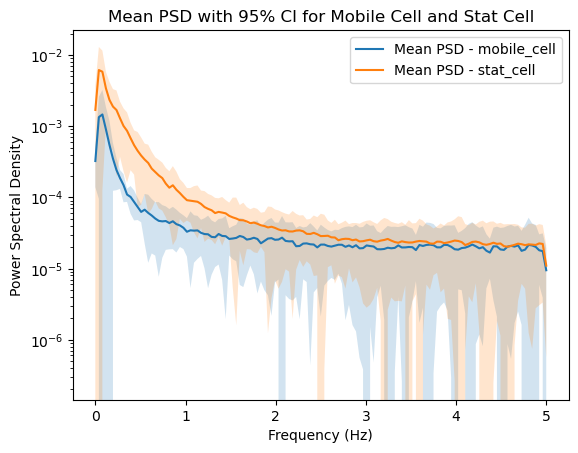

<Figure size 640x480 with 0 Axes>

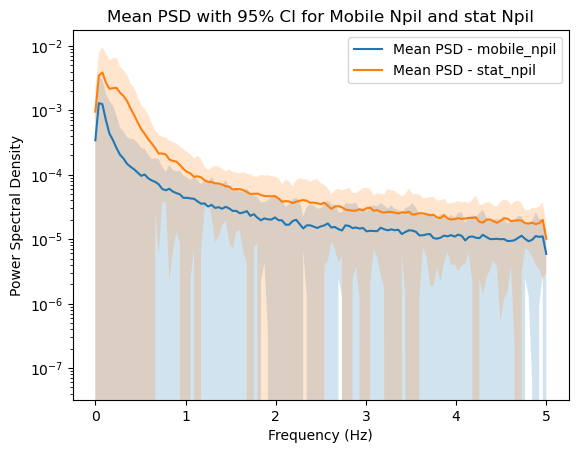

<Figure size 640x480 with 0 Axes>

In [34]:
# Assuming sima_folders is a list of folder names and results_df is your DataFrame

# Retrieve the frequency array from the first folder
freq_array = results_df["stat_cell"][sima_folders[0]]["freq"]


# Function to calculate mean and SEM
def calculate_mean_sem(data_arrays):
    stack = np.vstack(data_arrays)
    mean = np.mean(stack, axis=0)
    sem = stats.sem(stack, axis=0)
    ci = sem * stats.t.ppf((1 + 0.95) / 2.0, len(data_arrays) - 1)
    return mean, ci


# Plot for mobile_cell and stat_cell
plt.figure()
for condition in ["mobile_cell", "stat_cell"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in sima_folders]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(freq_array, mean, label=f"Mean PSD - {condition}")
    plt.fill_between(freq_array, mean - ci, mean + ci, alpha=0.2)

plt.title("Mean PSD with 95% CI for Mobile Cell and Stat Cell")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.show()
plt.savefig(
    "Dendritic Mean PSD with 95% CI for Mobile dendrite and Stat dendrite.png", dpi=300
)

# Plot for mobile_npil and stat_npil
plt.figure()
for condition in ["mobile_npil", "stat_npil"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in sima_folders]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(freq_array, mean, label=f"Mean PSD - {condition}")
    plt.fill_between(freq_array, mean - ci, mean + ci, alpha=0.2)

plt.title("Mean PSD with 95% CI for Mobile Npil and stat Npil")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.show()
plt.savefig(
    "Dendritic Mean PSD with 95% CI for Mobile npil and Stat nplit.png", dpi=300
)

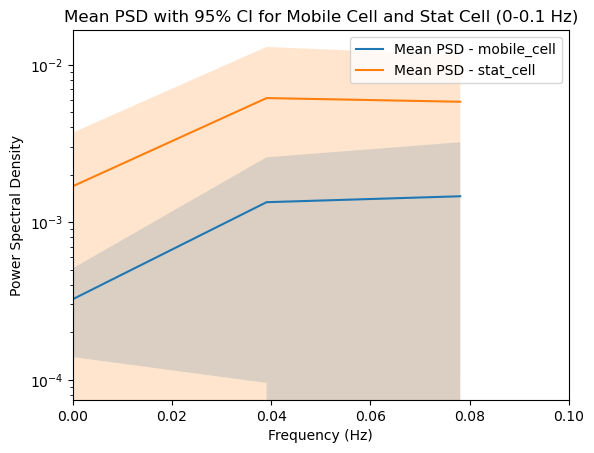

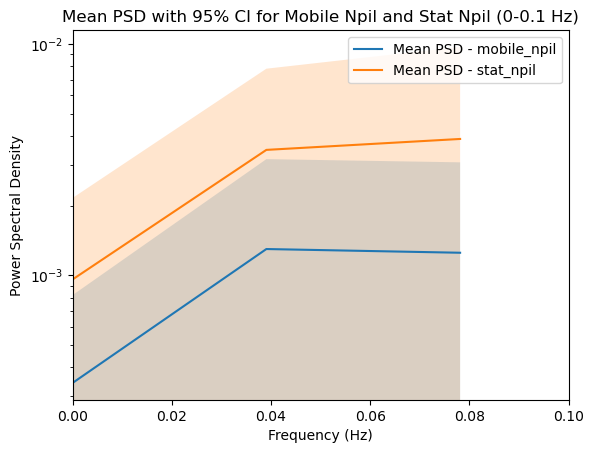

In [32]:
# Retrieve the frequency array from the first folder
freq_array = results_df["stat_cell"][sima_folders[0]]["freq"]


# Function to calculate mean and SEM
def calculate_mean_sem(data_arrays):
    stack = np.vstack(data_arrays)
    mean = np.mean(stack, axis=0)
    sem = stats.sem(stack, axis=0)
    ci = sem * stats.t.ppf((1 + 0.95) / 2.0, len(data_arrays) - 1)
    return mean, ci


# Find indices for the 0 to 0.1 frequency range
freq_indices = np.where((freq_array >= 0) & (freq_array <= 0.1))[0]

# Plot for mobile_cell and stat_cell in the 0 to 0.1 frequency range
plt.figure()
for condition in ["mobile_cell", "stat_cell"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in sima_folders]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(
        freq_array[freq_indices], mean[freq_indices], label=f"Mean PSD - {condition}"
    )
    plt.fill_between(
        freq_array[freq_indices],
        mean[freq_indices] - ci[freq_indices],
        mean[freq_indices] + ci[freq_indices],
        alpha=0.2,
    )

plt.title("Mean PSD with 95% CI for Mobile Cell and Stat Cell (0-0.1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0, 0.1)  # Set x-axis limit to 0 to 0.1 Hz
plt.legend()
plt.show()

# Repeat for mobile_npil and stat_npil
plt.figure()
for condition in ["mobile_npil", "stat_npil"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in sima_folders]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(
        freq_array[freq_indices], mean[freq_indices], label=f"Mean PSD - {condition}"
    )
    plt.fill_between(
        freq_array[freq_indices],
        mean[freq_indices] - ci[freq_indices],
        mean[freq_indices] + ci[freq_indices],
        alpha=0.2,
    )

plt.title("Mean PSD with 95% CI for Mobile Npil and Stat Npil (0-0.1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0, 0.1)  # Set x-axis limit to 0 to 0.1 Hz
plt.legend()
plt.show()

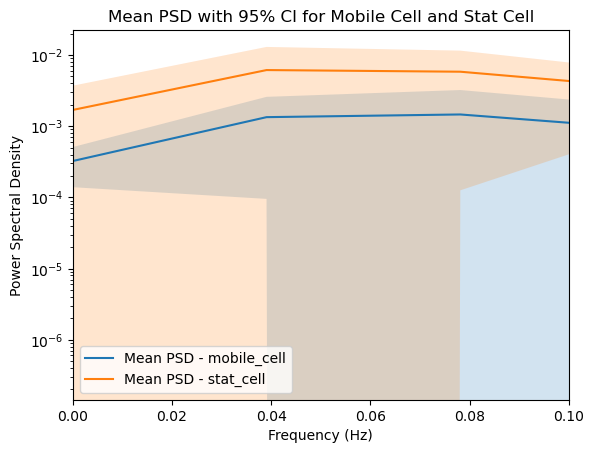

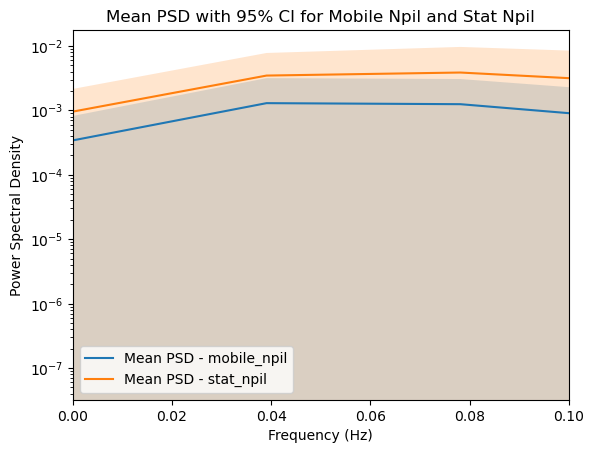

In [33]:
# Retrieve the frequency array from the first folder
freq_array = results_df["stat_cell"][sima_folders[0]]["freq"]


# Function to calculate mean and SEM
def calculate_mean_sem(data_arrays):
    stack = np.vstack(data_arrays)
    mean = np.mean(stack, axis=0)
    sem = stats.sem(stack, axis=0)
    ci = sem * stats.t.ppf((1 + 0.95) / 2.0, len(data_arrays) - 1)
    return mean, ci


# Plot for mobile_cell and stat_cell
plt.figure()
for condition in ["mobile_cell", "stat_cell"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in sima_folders]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(freq_array, mean, label=f"Mean PSD - {condition}")
    plt.fill_between(freq_array, mean - ci, mean + ci, alpha=0.2)

plt.title("Mean PSD with 95% CI for Mobile Cell and Stat Cell")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0, 0.1)  # Set x-axis limit to 0 to 0.1 Hz
plt.legend()
plt.show()

# Plot for mobile_npil and stat_npil
plt.figure()
for condition in ["mobile_npil", "stat_npil"]:
    psd_arrays = [results_df[condition][folder]["psd"] for folder in sima_folders]
    mean, ci = calculate_mean_sem(psd_arrays)
    plt.semilogy(freq_array, mean, label=f"Mean PSD - {condition}")
    plt.fill_between(freq_array, mean - ci, mean + ci, alpha=0.2)

plt.title("Mean PSD with 95% CI for Mobile Npil and Stat Npil")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0, 0.1)  # Set x-axis limit to 0 to 0.1 Hz
plt.legend()
plt.show()